# Task: Feature importance

I have a dataset and want to know which features are important for the target variable. I know that I can look at the coefficients of a linear model to get some kind of feature importance.

In [1]:
!pip install icecream

In [31]:
import pickle
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import RidgeCV, LinearRegression, Ridge
from scipy.stats import pearsonr
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from icecream import ic
import matplotlib.pyplot as plt
from prettytable import PrettyTable
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import norm
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import pointbiserialr
from sklearn.decomposition import PCA

## Load data

In [53]:
with open("/content/task3_feature-importance_data.pickle", "rb") as f:
    X, y = pickle.load(f)

#Data Exploration & EDA:

In [4]:
# Check for missing or null values
missing_values_count = np.sum(np.isnan(X))
ic("Number of missing values:", missing_values_count)

ic| 'Number of missing values:', missing_values_count: 0


('Number of missing values:', 0)

In [5]:
x_table = PrettyTable()
x_table.field_names = [f"\033[1mFeature {i}\033[0m" for i in range(X.shape[1])]  # Bold header
for row in X[:20]:  # Only the first 20 rows
    x_table.add_row(row)

y_table = PrettyTable()
y_table.field_names = ["\033[1mTarget\033[0m"]
for value in y[:20]:
    y_table.add_row([value])

print("First 20 rows of X Data:")
print(x_table)

print("\nFirst 20 values of y Data:")
print(y_table)

First 20 rows of X Data:
+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+----------------------+-----------+-----------+----------------------+
|      Feature 0       |      Feature 1       |      Feature 2       |       Feature 3       |       Feature 4       |       Feature 5       |      Feature 6       | Feature 7 | Feature 8 |      Feature 9       |
+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+----------------------+-----------+-----------+----------------------+
|  0.5015037572815358  | 0.19183730014201025  | -1.5649340817317423  |  -0.6726200460247509  |   0.5292935838669609  |  -0.9720689910920556  | 0.012839883482549188 |    0.0    |    1.0    |  2.117751181377709   |
| -1.1742421907909417  | 0.20001799647853574  |  2.1768649289411335  |   2.0201769407320693  |   1.5959168681911275  |  -0.

ic| info_summary_table: +-------------+------------+
                        | Information |   Value    |
                        +-------------+------------+
                        | X shape     | (1000, 10) |
                        | y shape     |  (1000,)   |
                        +-------------+------------+
ic| stats_summary_table: +-----------+------------------------+--------------------+
                         |  Feature  |          Mean          | Standard Deviation |
                         +-----------+------------------------+--------------------+
                         | Feature 0 | -0.015764937640709735  | 1.0190680776109609 |
                         | Feature 1 | -0.0049655644459222666 | 0.9639954044394664 |
                         | Feature 2 | -0.023935348856827035  | 1.0203107582703195 |
                         | Feature 3 | -0.026094916579989955  | 0.9787021800775941 |
                         | Feature 4 |  0.02232984360667343   | 1.0150662714347485 |
  

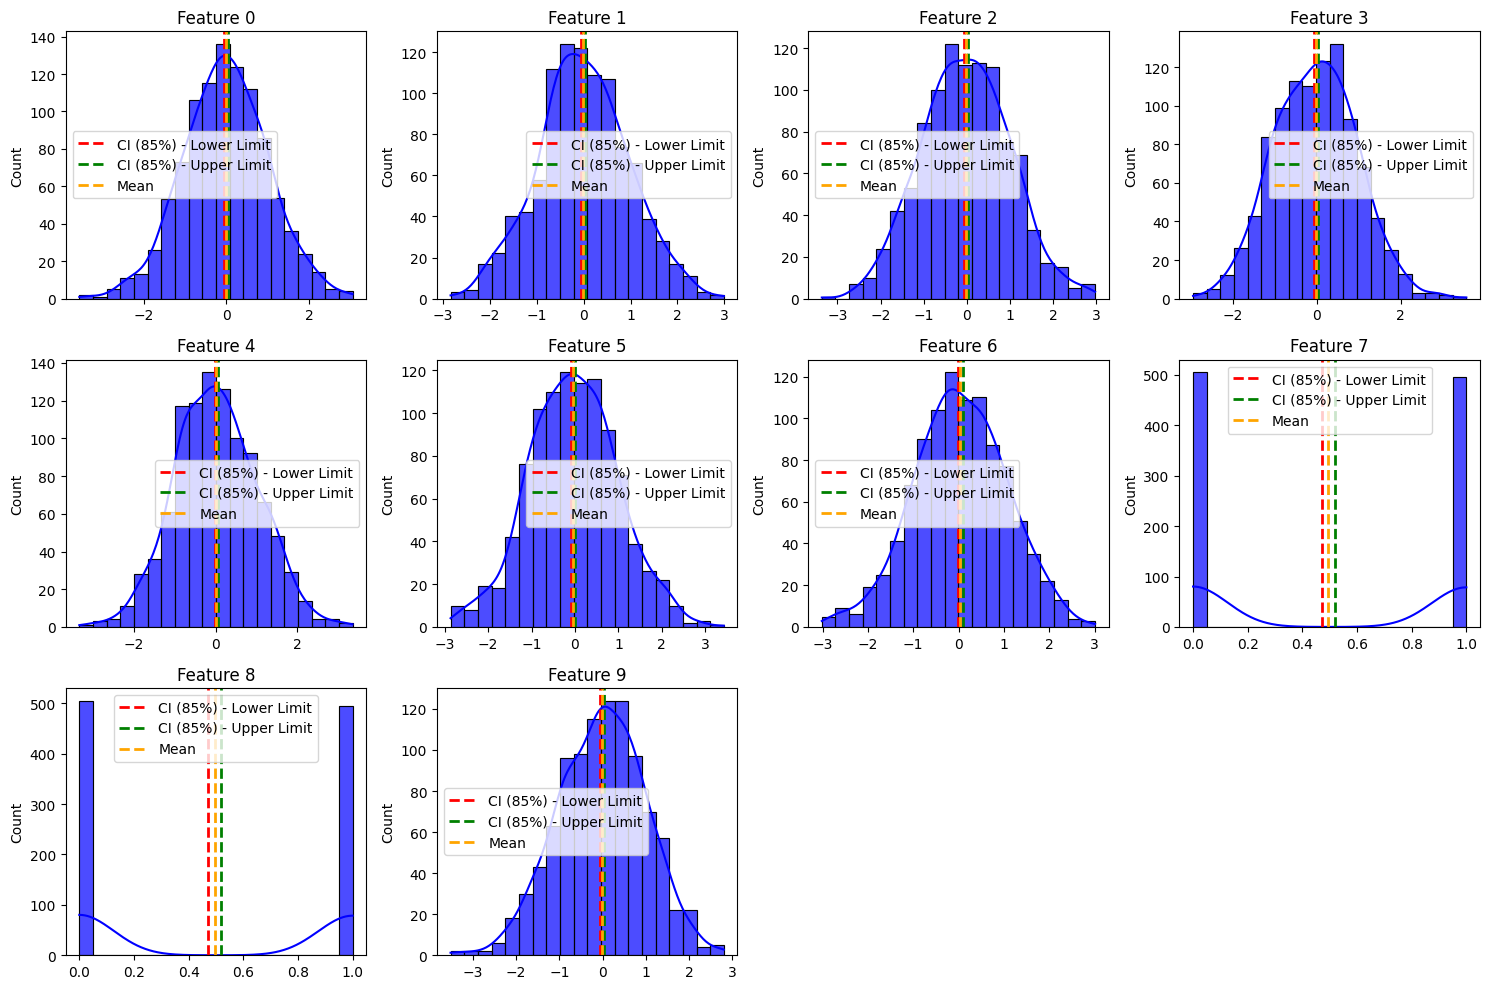

In [51]:
# Create table for information summary
info_summary_table = PrettyTable()
info_summary_table.field_names = ["Information", "Value"]
info_summary_table.align["Information"] = "l"
info_summary_table.add_row(["X shape", X.shape])
info_summary_table.add_row(["y shape", y.shape])

# Calculate summary statistics for X
mean_features = np.mean(X, axis=0)
std_features = np.std(X, axis=0)

# Create table for summary statistics
stats_summary_table = PrettyTable()
stats_summary_table.field_names = ["Feature", "Mean", "Standard Deviation"]
for i, (mean, std) in enumerate(zip(mean_features, std_features)):
    stats_summary_table.add_row([f"Feature {i}", mean, std])
ic(info_summary_table)
ic(stats_summary_table)

# Visualize distributions of features using histograms with confidence intervals
num_features = X.shape[1]
plt.figure(figsize=(15, 10))
for i in range(num_features):
    plt.subplot(3, 4, i + 1)
    sns.histplot(X[:, i], bins=20, kde=True, color='blue', alpha=0.7)

    # Calculate confidence interval
    mean, std = np.mean(X[:, i]), np.std(X[:, i])
    confidence_interval = norm.interval(0.85, loc=mean, scale=std / np.sqrt(len(X[:, i])))
    lower_limit, upper_limit = confidence_interval[0], confidence_interval[1]

    plt.axvline(lower_limit, color='red', linestyle='dashed', linewidth=2, label='CI (85%) - Lower Limit')
    plt.axvline(upper_limit, color='green', linestyle='dashed', linewidth=2, label='CI (85%) - Upper Limit')
    plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label='Mean')

    plt.title(f"Feature {i}")
    plt.legend()

plt.tight_layout()
plt.show()

There are 1,000 samples total in the dataset, and each sample has 10 characteristics (X shapes) and a corresponding target variable (Y shapes). The mean and standard deviation for each feature are highlighted in a summary of the statistics for the features. Notably, features 7 and 8, which are binary characteristics with mean values of roughly 0.495 and a nearly equal distribution of 0s and 1s, respectively, are the final two features. These binary features have a standard deviation that is very nearly 0.5, which is indicative of their binary nature. The averages and standard deviations of the other numerical features differ.

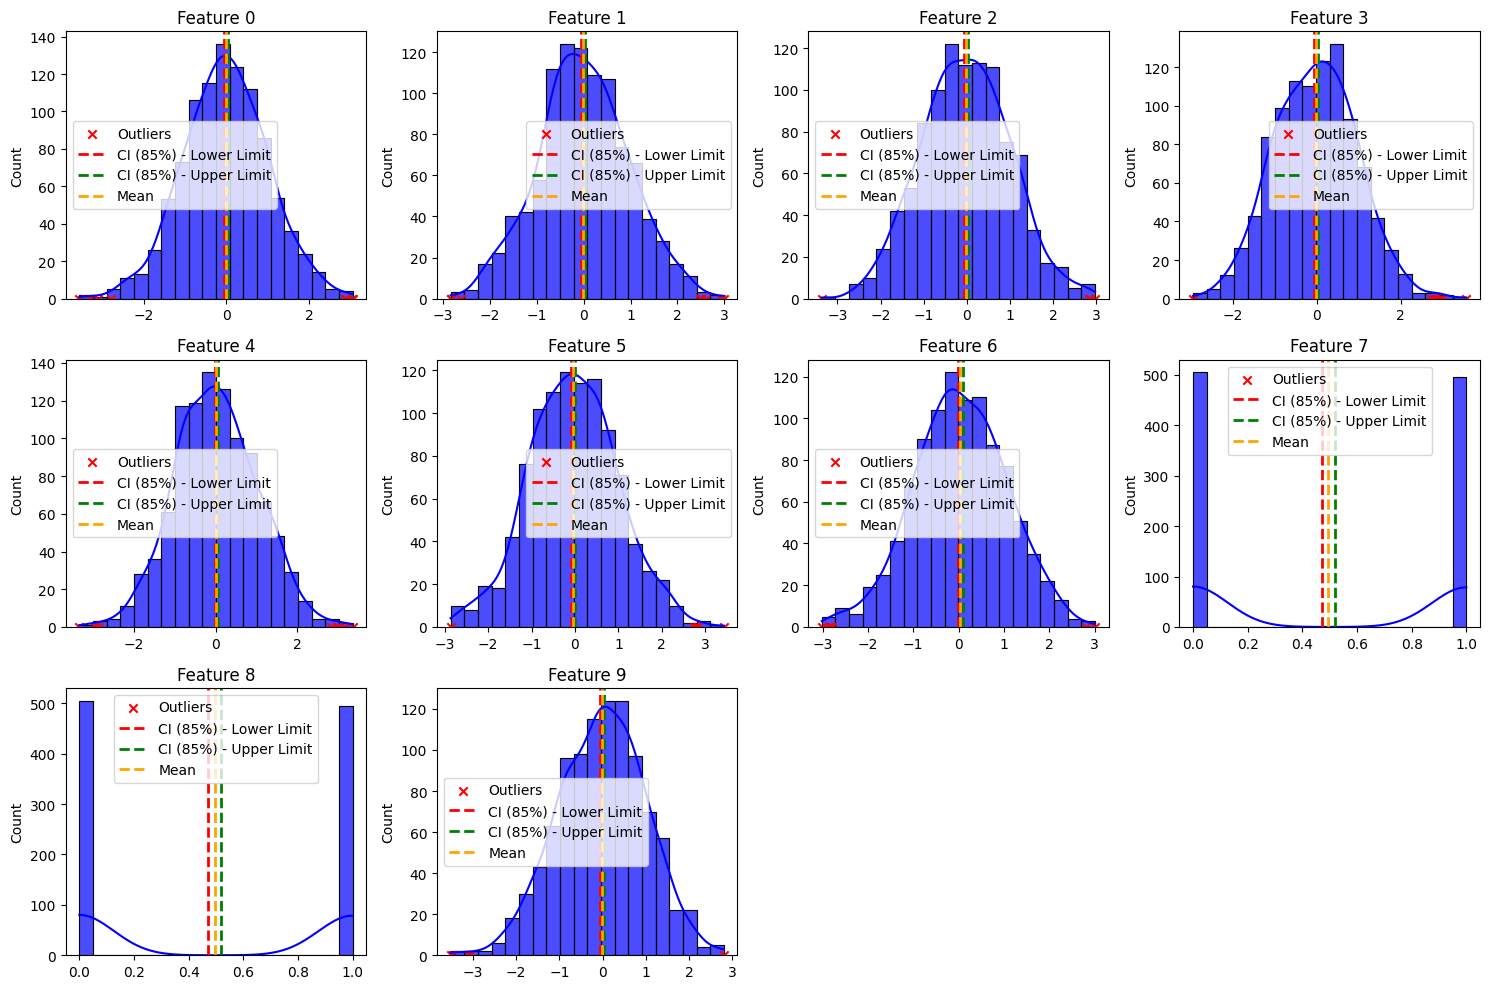

In [55]:
#Checking outliers

# Visualize distributions of features using histograms with confidence intervals and outliers
num_features = X.shape[1]
plt.figure(figsize=(15, 10))
for i in range(num_features):
    plt.subplot(3, 4, i + 1)
    sns.histplot(X[:, i], bins=20, kde=True, color='blue', alpha=0.7)

    # Calculate confidence interval
    mean, std = np.mean(X[:, i]), np.std(X[:, i])
    confidence_interval = norm.interval(0.85, loc=mean, scale=std / np.sqrt(len(X[:, i])))
    lower_limit, upper_limit = confidence_interval[0], confidence_interval[1]

    # Identify outliers using IQR
    iqr = np.percentile(X[:, i], 75) - np.percentile(X[:, i], 25)
    lower_threshold = np.percentile(X[:, i], 25) - 1.5 * iqr
    upper_threshold = np.percentile(X[:, i], 75) + 1.5 * iqr

    # Mark outliers with red crosses
    outliers = X[(X[:, i] < lower_threshold) | (X[:, i] > upper_threshold), i]
    plt.scatter(outliers, np.zeros_like(outliers), color='red', marker='x', label='Outliers')

    plt.axvline(lower_limit, color='red', linestyle='dashed', linewidth=2, label='CI (85%) - Lower Limit')
    plt.axvline(upper_limit, color='green', linestyle='dashed', linewidth=2, label='CI (85%) - Upper Limit')
    plt.axvline(mean, color='orange', linestyle='dashed', linewidth=2, label='Mean')

    plt.title(f"Feature {i}")
    plt.legend()

plt.tight_layout()
plt.show()

In [59]:
from scipy import stats
#Check amount of outliers
# Calculate Z-scores for each feature
z_scores = stats.zscore(X))
threshold = 3

# Find the number of outliers and non-outliers
outlier_counts = (np.abs(z_scores) > threshold).any(axis=1)
num_outliers = sum(outlier_counts)
num_non_outliers = len(X) - num_outliers

outlier_summary_table = PrettyTable()
outlier_summary_table.field_names = ["Category", "Count"]
outlier_summary_table.add_row(["Outliers", num_outliers])
outlier_summary_table.add_row(["Non-Outliers", num_non_outliers])

print(outlier_summary_table)

+--------------+-------+
|   Category   | Count |
+--------------+-------+
|   Outliers   |   19  |
| Non-Outliers |  981  |
+--------------+-------+


Amount of the outliers is pretty small to consider for removing them

ic| summary_table: +-------------------------+---------------------+
                   | Statistic               |        Value        |
                   +-------------------------+---------------------+
                   | Minimum y value         | -1220.0212137613564 |
                   | Maximum y value         |  372.6527846143699  |
                   | Mean y value            |  -2.800014463632955 |
                   | Standard deviation of y |  127.73940001857882 |
                   +-------------------------+---------------------+


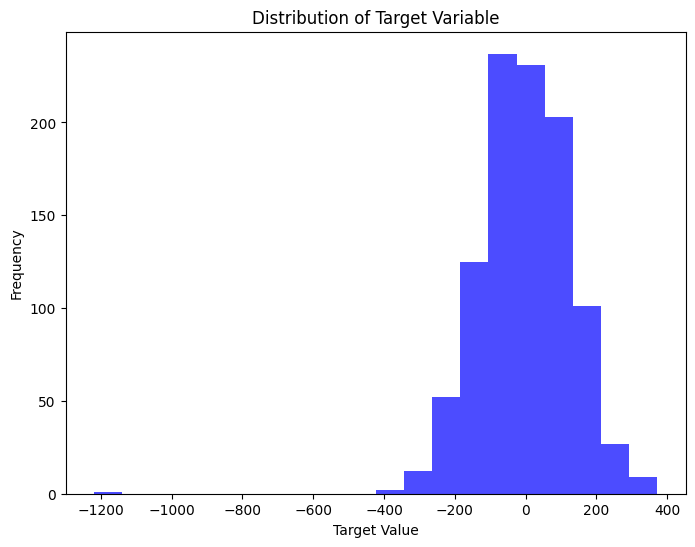

In [7]:
# Calculate summary statistics for y
min_y = np.min(y)
max_y = np.max(y)
mean_y = np.mean(y)
std_y = np.std(y)

summary_table = PrettyTable()
summary_table.field_names = ["Statistic", "Value"]
summary_table.align["Statistic"] = "l"
summary_table.add_row(["Minimum y value", min_y])
summary_table.add_row(["Maximum y value", max_y])
summary_table.add_row(["Mean y value", mean_y])
summary_table.add_row(["Standard deviation of y", std_y])

ic(summary_table)

# Visualize the distribution of the target variable with custom color
plt.figure(figsize=(8, 6))
plt.hist(y, bins=20, color='blue', alpha=0.7)
plt.title("Distribution of Target Variable")
plt.xlabel("Target Value")
plt.ylabel("Frequency")
plt.show()

In [14]:
# Calculate confidence interval for the proportion of ones in feature 7
proportion_7 = np.mean(X[:, 7])
ci_7 = proportion_confint(np.sum(X[:, 7]), len(X[:, 7]))

# Calculate confidence interval for the proportion of ones in feature 8
proportion_8 = np.mean(X[:, 8])
ci_8 = proportion_confint(np.sum(X[:, 8]), len(X[:, 8]))

table = PrettyTable()
table.field_names = ["Feature", "Proportion", "Confidence Interval"]

table.add_row(["Feature 7", f"{proportion_7:.2f}", f"({ci_7[0]:.2f}, {ci_7[1]:.2f})"])
table.add_row(["Feature 8", f"{proportion_8:.2f}", f"({ci_8[0]:.2f}, {ci_8[1]:.2f})"])

print(table)

+-----------+------------+---------------------+
|  Feature  | Proportion | Confidence Interval |
+-----------+------------+---------------------+
| Feature 7 |    0.49    |     (0.46, 0.53)    |
| Feature 8 |    0.49    |     (0.46, 0.53)    |
+-----------+------------+---------------------+


The proportions and confidence intervals for features 7 and 8 appear to be identical. This means that the confidence intervals are similar and that the proportion of the data points for each features is roughly 0.49.

Given that both of these features are binary and that the proportions are about 0.5, it is possible that the data is roughly evenly distributed between the two possible values (0 and 1) for each feature.

In [15]:
# Count 0s and 1s in feature 7 and 8
feature_7_zeros = sum(X[:, 7] == 0)
feature_7_ones = sum(X[:, 7] == 1)

feature_8_zeros = sum(X[:, 8] == 0)
feature_8_ones = sum(X[:, 8] == 1)

ic(f"Feature 7: Number of 0s = {feature_7_zeros}, Number of 1s = {feature_7_ones}")
ic(f"Feature 8: Number of 0s = {feature_8_zeros}, Number of 1s = {feature_8_ones}")

ic| f"Feature 7: Number of 0s = {feature_7_zeros}, Number of 1s = {feature_7_ones}": 'Feature 7: Number of 0s = 505, Number of 1s = 495'
ic| f"Feature 8: Number of 0s = {feature_8_zeros}, Number of 1s = {feature_8_ones}": 'Feature 8: Number of 0s = 505, Number of 1s = 495'


'Feature 8: Number of 0s = 505, Number of 1s = 495'

In [17]:
# Calculate the point biserial correlation between feature 7 and the target variable
phi_7, p_7 = pointbiserialr(X[:, 7], y)
phi_8, p_8 = pointbiserialr(X[:, 8], y)

ic(f"Feature 7 vs Target: Phi coefficient = {phi_7:.2f}, p-value = {p_7:.4f}")
ic(f"Feature 8 vs Target: Phi coefficient = {phi_8:.2f}, p-value = {p_8:.4f}")

ic| f"Feature 7 vs Target: Phi coefficient = {phi_7:.2f}, p-value = {p_7:.4f}": 'Feature 7 vs Target: Phi coefficient = -0.01, p-value = 0.7588'
ic| f"Feature 8 vs Target: Phi coefficient = {phi_8:.2f}, p-value = {p_8:.4f}": 'Feature 8 vs Target: Phi coefficient = 0.02, p-value = 0.4429'


'Feature 8 vs Target: Phi coefficient = 0.02, p-value = 0.4429'

The p-value aids in determining the statistical significance of the link between two binary variables, as measured by the phi coefficient.
#Association between feature 7 and Target:
The Phi coefficient runs from -1 to 1, therefore it is equal to 0.01. A result that is close to 0 (such as -0.01) denotes a weak connection between the variables. In this instance, there is only a very weak negative correlation between Feature 7 and the target variable.
p-value = 0.7588: The p-value assesses the strength of the evidence opposing the null hypothesis, according to which there is no correlation between the variables. A p-value of 0.7588 or higher indicates that there is insufficient evidence to reject the null hypothesis. In other words, the seeming modest negative correlation may simply be the result of chance.
#Association between feature 8 and Target:
Phi Coefficient = 0.02: In a similar manner, a Phi coefficient of 0.02 shows an extremely weak positive correlation between Feature 8 and the intended variable.
The p-value is 0.4429. The null hypothesis that there is no correlation between Feature 8 and the target variable cannot be rejected, according to the p-value of 0.4429.



In [19]:
# Create a DataFrame for "cross-tabulation"
df = pd.DataFrame({'Feature 7': X[:, 7], 'Feature 8': X[:, 8], 'Target': y})

cross_tab = pd.crosstab(df['Feature 7'], df['Feature 8'])

table = PrettyTable()
table.field_names = ["", "Feature 8 = 0", "Feature 8 = 1"]
for idx, row in cross_tab.iterrows():
    table.add_row([f"Feature 7 = {idx}", row[0], row[1]])

ic("Cross-Tabulation:")
print(table)

ic| 'Cross-Tabulation:'


+-----------------+---------------+---------------+
|                 | Feature 8 = 0 | Feature 8 = 1 |
+-----------------+---------------+---------------+
| Feature 7 = 0.0 |       10      |      495      |
| Feature 7 = 1.0 |      495      |       0       |
+-----------------+---------------+---------------+


The distribution and connection between Features 7 and 8 are shown in this table. When Feature 7 is 1.0, Feature 8 always appears to be 0.0, and when Feature 7 is 0.0, Feature 8 tends to be 1. This pattern shows that Feature 7 and Feature 8 may be closely coupled in a certain way or may have a relationship that is mutually exclusive.

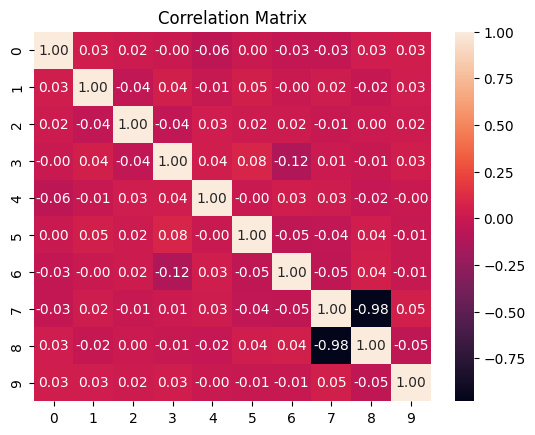

Highly Correlated Feature Pairs:
Features 7 and 8 are highly correlated with a correlation of -0.98
Features 8 and 7 are highly correlated with a correlation of -0.98


In [20]:
# Perform a correlation matrix plot to visualize feature correlations
correlation_matrix = np.corrcoef(X, rowvar=False)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

# Find highly correlated feature pairs
correlation_threshold = 0.5
highly_correlated_pairs = np.where(np.abs(correlation_matrix) > correlation_threshold)

print("Highly Correlated Feature Pairs:")
for i, j in zip(highly_correlated_pairs[0], highly_correlated_pairs[1]):
    if i != j:
        print(f"Features {i} and {j} are highly correlated with a correlation of {correlation_matrix[i, j]:.2f}")

According to the outcome, Features 7 and 8 have a strong link (correlation coefficient: -0.98). This suggests that, as we previously observed, when one of the is 0 the other is 1, while the value of Feature 7 grows, the value of Feature 8 tends to decrease. When two features carry similar information, there may be duplication in our data, which is indicated by a high correlation between them. In this situation, highly correlated characteristics may result in **multicollinearity**, which may impact the model's **stability** and **interpretability**.

*My recomendation*: In this situation, since they are highly connected and carry comparable information, we may decide to preserve only one of them in order to streamline the model and make it easier to understand.

## Fit model

In [23]:
model = make_pipeline(StandardScaler(), RidgeCV())
model.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()), ('ridgecv', RidgeCV())])

In [60]:
# Load data again
with open("/content/task3_feature-importance_data.pickle", "rb") as f:
    X, y = pickle.load(f)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 10), (200, 10), (800,), (200,))

In [61]:
# Evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 1018.4360
R-squared: 0.9283


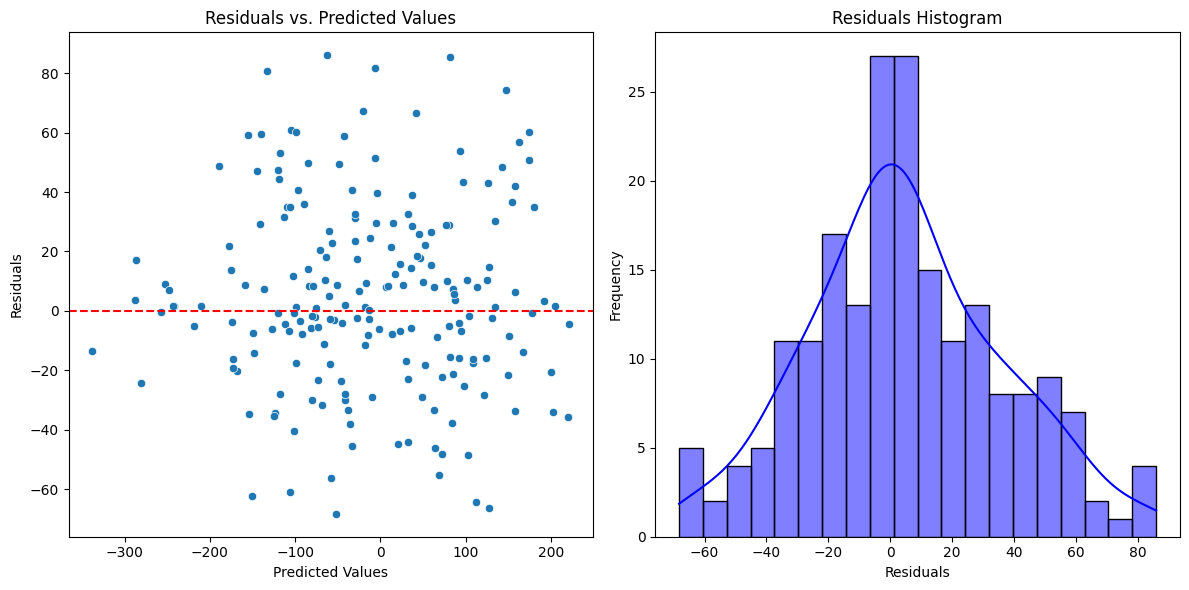

In [64]:
# Calculate residuals
residuals = y_test- y_pred
plt.figure(figsize=(12, 6))

# Residuals vs. Predicted Values
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.histplot(residuals, bins=20, kde=True, color='blue')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [26]:
# Remove Feature 7 from the dataset
X_train_no_feature7 = np.delete(X_train, 7, axis=1)
X_test_no_feature7 = np.delete(X_test, 7, axis=1)

# Create and fit the Ridge regression model without Feature 7
model_no_feature7 = make_pipeline(StandardScaler(), RidgeCV())
model_no_feature7.fit(X_train_no_feature7, y_train)

# Evaluate the model without Feature 7
y_pred_no_feature7 = model_no_feature7.predict(X_test_no_feature7)
mse_no_feature7 = mean_squared_error(y_test, y_pred_no_feature7)
r2_no_feature7 = r2_score(y_test, y_pred_no_feature7)

print("Model without Feature 7:")
print(f"Mean Squared Error: {mse_no_feature7:.4f}")
print(f"R-squared: {r2_no_feature7:.4f}")


Model without Feature 7:
Mean Squared Error: 1005.7560
R-squared: 0.9292


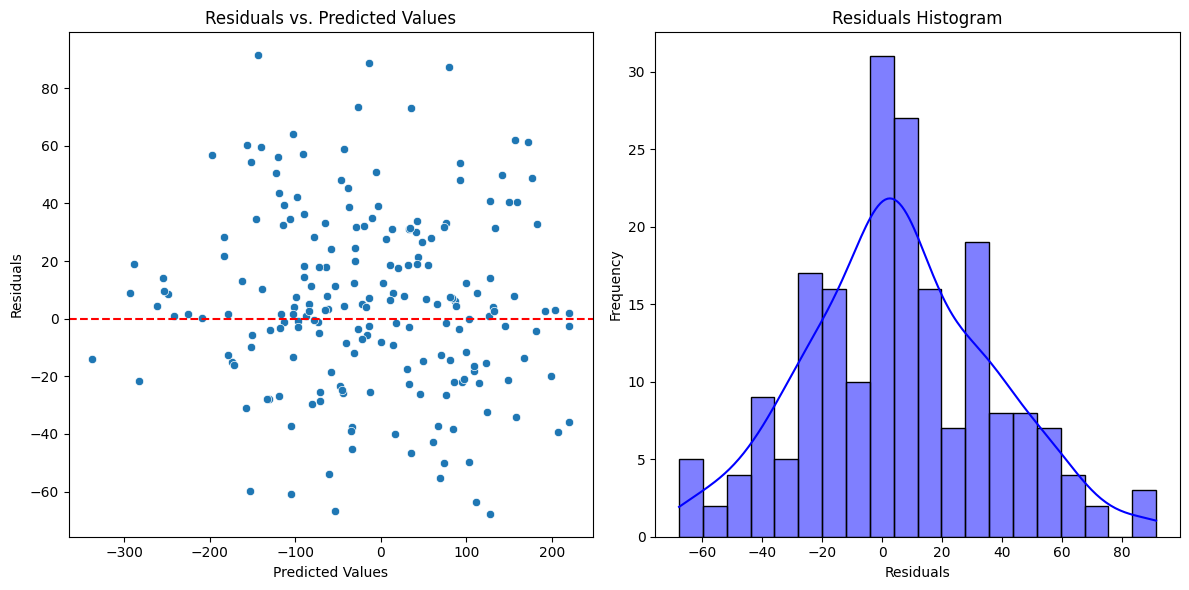

In [66]:
# Calculate residuals
residuals_7 = y_test- y_pred_no_feature7
plt.figure(figsize=(12, 6))

# Residuals vs. Predicted Values
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_no_feature7, y=residuals_7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.histplot(residuals_7, bins=20, kde=True, color='blue')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
# Load data again
with open("/content/task3_feature-importance_data.pickle", "rb") as f:
    X, y = pickle.load(f)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Remove Feature 8 from the dataset
X_train_no_feature8 = np.delete(X_train, 8, axis=1)
X_test_no_feature8 = np.delete(X_test, 8, axis=1)

# Create and fit the Ridge regression model without Feature 8
model_no_feature8 = make_pipeline(StandardScaler(), RidgeCV())
model_no_feature8.fit(X_train_no_feature8, y_train)

# Evaluate the model without Feature 8
y_pred_no_feature8 = model_no_feature8.predict(X_test_no_feature8)
mse_no_feature8 = mean_squared_error(y_test, y_pred_no_feature8)
r2_no_feature8 = r2_score(y_test, y_pred_no_feature8)

print("Model without Feature 8:")
print(f"Mean Squared Error: {mse_no_feature8:.4f}")
print(f"R-squared: {r2_no_feature8:.4f}")


Model without Feature 8:
Mean Squared Error: 979.9343
R-squared: 0.9310


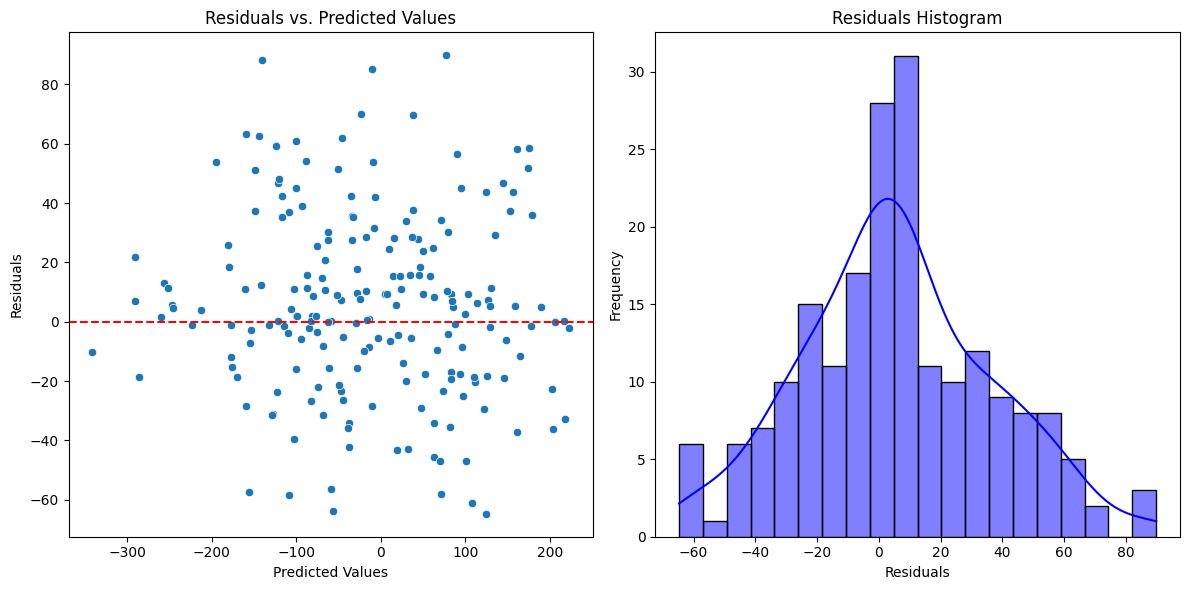

In [67]:
# Calculate residuals
residuals_8 = y_test- y_pred_no_feature8
plt.figure(figsize=(12, 6))

# Residuals vs. Predicted Values
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_no_feature8, y=residuals_8)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.histplot(residuals_8, bins=20, kde=True, color='blue')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [28]:
# Load data again
with open("/content/task3_feature-importance_data.pickle", "rb") as f:
    X, y = pickle.load(f)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine Feature 7 and Feature 8
combined_feature = np.logical_or(X_train[:, 7], X_train[:, 8])
combined_feature = combined_feature.astype(int)  # Convert Boolean to integer

X_train_combined = np.delete(X_train, [7, 8], axis=1)
X_train_combined = np.insert(X_train_combined, 7, combined_feature, axis=1)

combined_feature = np.logical_or(X_test[:, 7], X_test[:, 8])
combined_feature = combined_feature.astype(int)

X_test_combined = np.delete(X_test, [7, 8], axis=1)
X_test_combined = np.insert(X_test_combined, 7, combined_feature, axis=1)

# Create and fit the Ridge regression model with combined feature
model_combined = make_pipeline(StandardScaler(), RidgeCV())
model_combined.fit(X_train_combined, y_train)

# Evaluate the model with combined feature
y_pred_combined = model_combined.predict(X_test_combined)
mse_combined = mean_squared_error(y_test, y_pred_combined)
r2_combined = r2_score(y_test, y_pred_combined)

print("Model with Combined Feature 7 and 8:")
print(f"Mean Squared Error: {mse_combined:.4f}")
print(f"R-squared: {r2_combined:.4f}")


Model with Combined Feature 7 and 8:
Mean Squared Error: 1345.8229
R-squared: 0.9053


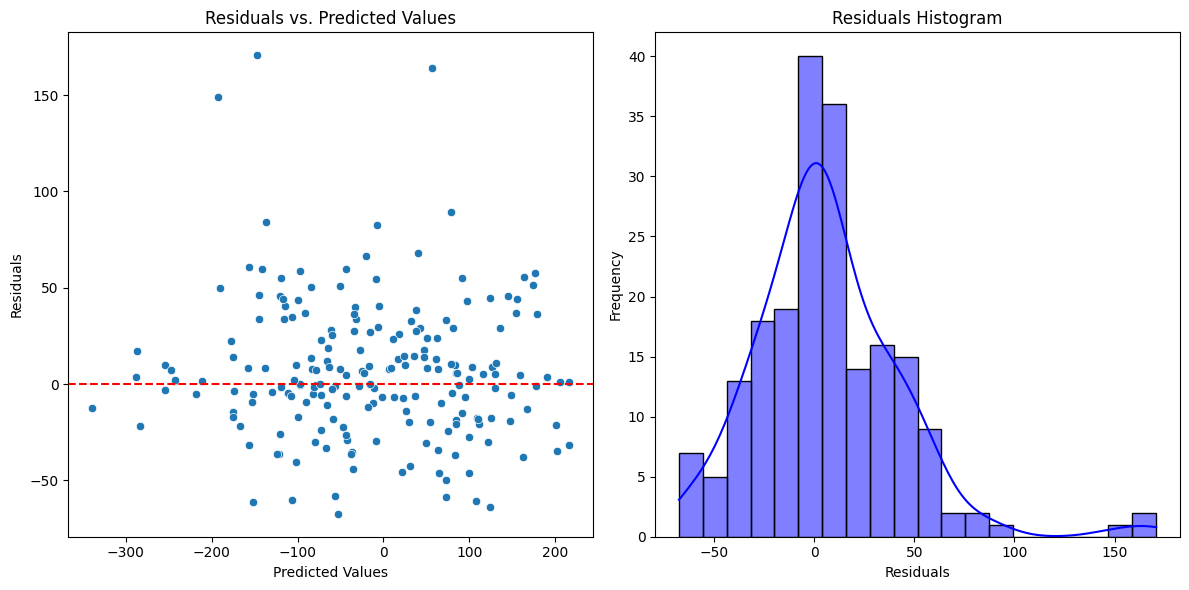

In [68]:
# Calculate residuals
residuals_combi = y_test- y_pred_combined
plt.figure(figsize=(12, 6))

# Residuals vs. Predicted Values
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_pred_combined, y=residuals_combi)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
sns.histplot(residuals_combi, bins=20, kde=True, color='blue')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

1. The lower Mean Squared Error and higher R-squared value when Feature 8 was kept while Feature 7 was eliminated show that Feature 8 appears to have a bigger beneficial impact on the model's predictive performance than Feature 7.
2. The performance of the model was improved by removing either Feature 7 or Feature 8, suggesting that when combined, they might cause multicollinearity or noise.
3. The fact that combining characteristics 7 and 8 into a single feature did not produce better results shows that these characteristics have a special interaction that may be nonlinear and enhances the performance of the model.

## Analyse correlations and model coefficients
Let's look at the coefficients.

In [29]:
correlations_r = [pearsonr(X[:, i], y)[0] for i in range(X.shape[1])]
correlations_p = [pearsonr(X[:, i], y)[1] for i in range(X.shape[1])]

In [30]:
df = pd.DataFrame({
        "coef": model["ridgecv"].coef_,
        "correlation r": correlations_r,
        "correlation p": correlations_p},
    index=[f"feature {i}" for i in range(X.shape[1])])
df

,coef,correlation r,correlation p
feature 0,-1.529528,-0.034627,2.739660e-01
feature 1,0.516905,0.009749,7.581588e-01
feature 2,59.958697,0.496610,2.160929e-63
feature 3,0.053120,0.049881,1.149366e-01
feature 4,68.390912,0.554580,1.019725e-81
feature 5,72.159892,0.577704,4.339895e-90
feature 6,-2.134884,-0.021040,5.063249e-01
feature 7,39.197821,-0.009722,7.588043e-01
feature 8,40.087218,0.024289,4.429447e-01
feature 9,1.915710,0.013164,6.775740e-01


**Feature 7 (Coef: 39.197821, Correlation r: -0.009722, Correlation p: 0.7588)**

The fact that the coefficient (coef) is so large suggests that Feature 7 significantly affects the model's predictions.
The poor linear connection between Feature 7 and the goal is indicated by the correlation coefficient (correlation r), which is very close to 0.
The correlation p-value is high (0.7588), indicating that there is no statistically significant association between Feature 7 and the target.

**Feature 8 (Coef: 40.087218, Correlation r: 0.024289, Correlation p: 0.4429)**

Similar to Feature 7, the coefficient (coef) for this feature also has an impact on the model's predictions.
A modest linear connection between Feature 8 and the goal is shown by the correlation coefficient (correlation r), which is positive but still close to 0.
The correlation p-value (correlation p) is higher than Feature 7 (0.4429), indicating that there is no statistically significant association between Feature 8 and the target.

This explains why eliminating Feature 8 had a better effect on the model's performance than eliminating Feature 7. Despite having a higher coefficient, feature 8 may have been removed to improve the performance of the model because of its poor association with the target and likely multicollinearity with other features.

ic| variance_table: +-----------+--------------------------+
                    |  Feature  | Explained Variance Ratio |
                    +-----------+--------------------------+
                    | Feature 0 |    0.140512401489848     |
                    | Feature 1 |    0.1295808707017571    |
                    | Feature 2 |   0.12451484394960737    |
                    | Feature 3 |   0.11989388233184917    |
                    | Feature 4 |   0.11616265959672617    |
                    | Feature 5 |   0.11183232215603006    |
                    | Feature 6 |   0.10272864267217455    |
                    | Feature 7 |   0.09741339625046626    |
                    | Feature 8 |   0.05678547341236577    |
                    +-----------+--------------------------+


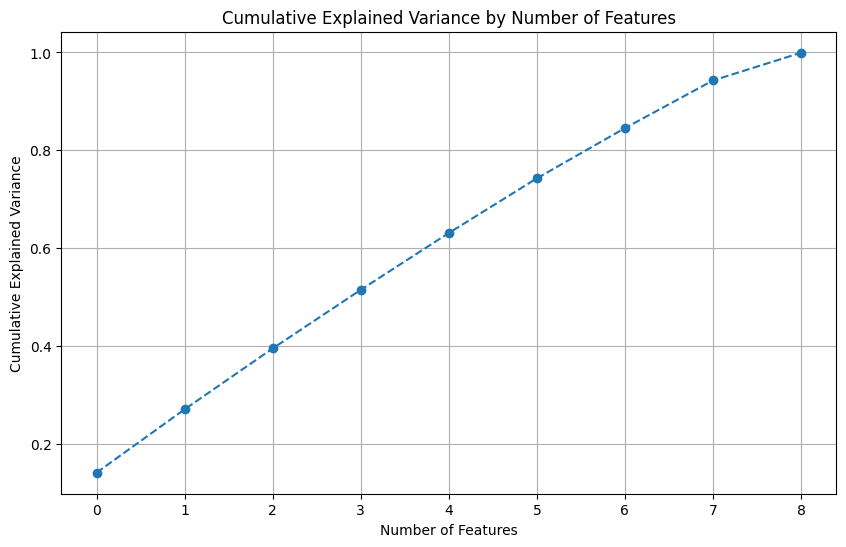

In [32]:
# Assuming X is your feature matrix
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X)

# Get explained variance ratios and cumulative explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

variance_table = PrettyTable()
variance_table.field_names = ["Feature", "Explained Variance Ratio"]
for i, ratio in enumerate(explained_variance_ratio):
    if i in [7, 8]:  # Highlight Features 7 and 8
        feature_name = f"\033[1;31mFeature {i}\033[0m"
        variance_table.add_row([feature_name, ratio])
    else:
        variance_table.add_row([f"Feature {i}", ratio])

ic(variance_table)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by Number of Features")
plt.grid(True)
plt.show()

then, in comparison to Feature 8, Feature 7 has a greater explained variance ratio. This indicates that Feature 7 captures more of the dataset's variability than Feature 8, according to the data.

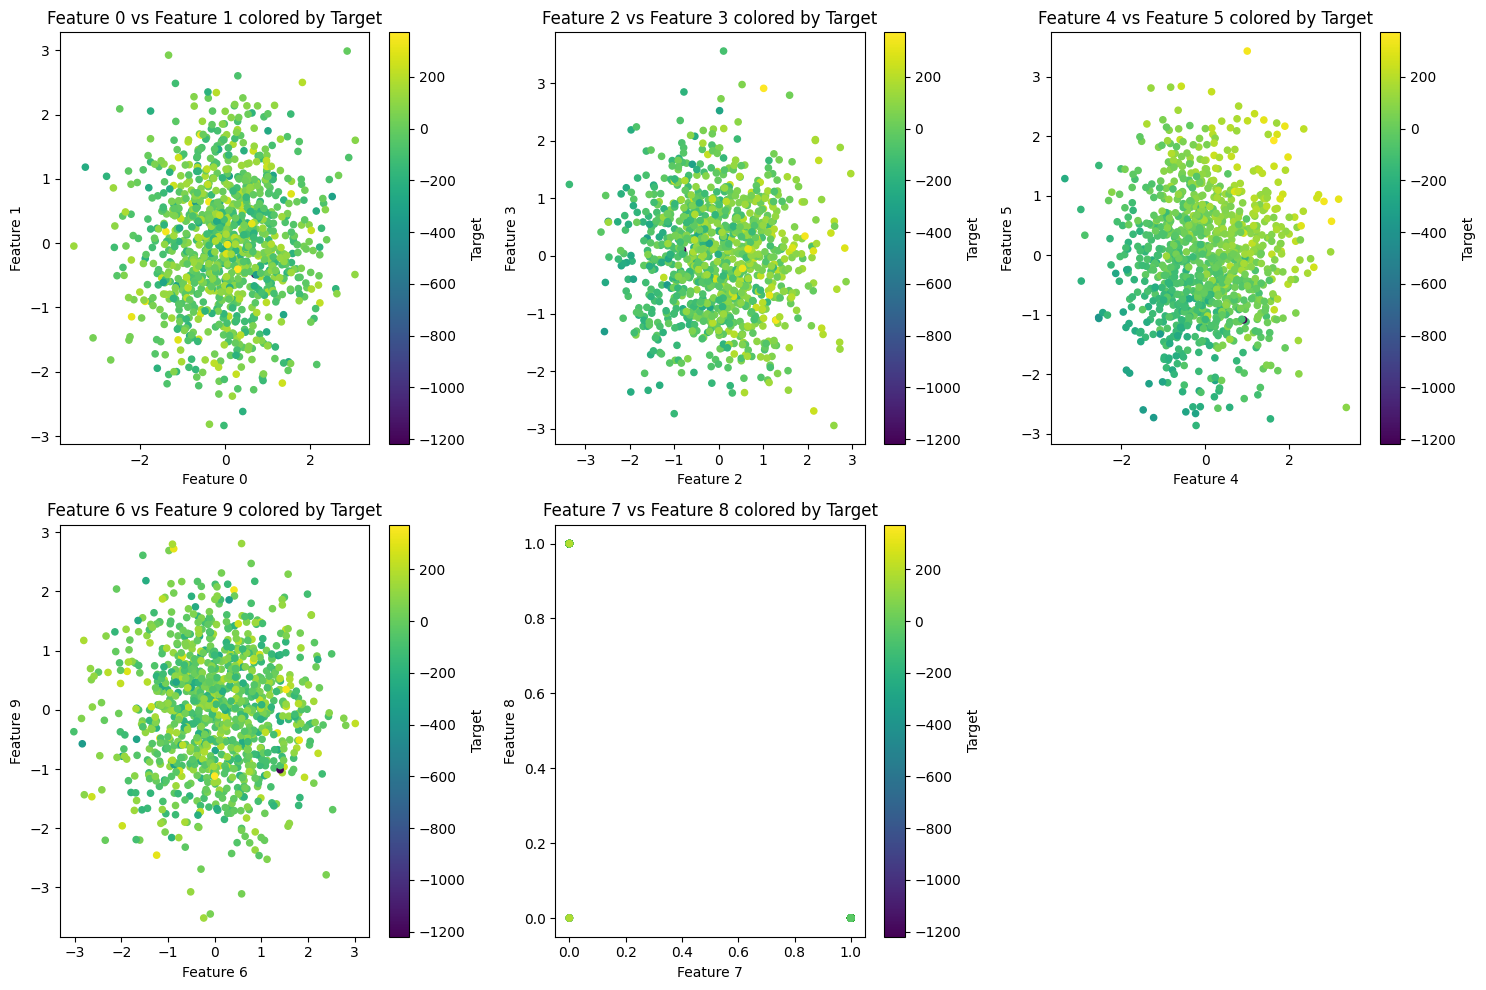

In [33]:
selected_features = [0, 1, 2, 3, 4, 5, 6,7, 8, 9]
X_selected = X[:, selected_features]

selected_pairs = [(0, 1), (2, 3), (4, 5), (6, 9), (7, 8)]
plt.figure(figsize=(15, 10))
for idx, (feature1, feature2) in enumerate(selected_pairs, start=1):
    plt.subplot(2, 3, idx)
    plt.scatter(X_selected[:, feature1], X_selected[:, feature2], c=y, cmap='viridis', s=20)
    plt.xlabel(f"Feature {feature1}")
    plt.ylabel(f"Feature {feature2}")
    plt.title(f"Feature {feature1} vs Feature {feature2} colored by Target")
    plt.colorbar(label='Target')
plt.tight_layout()
plt.show()

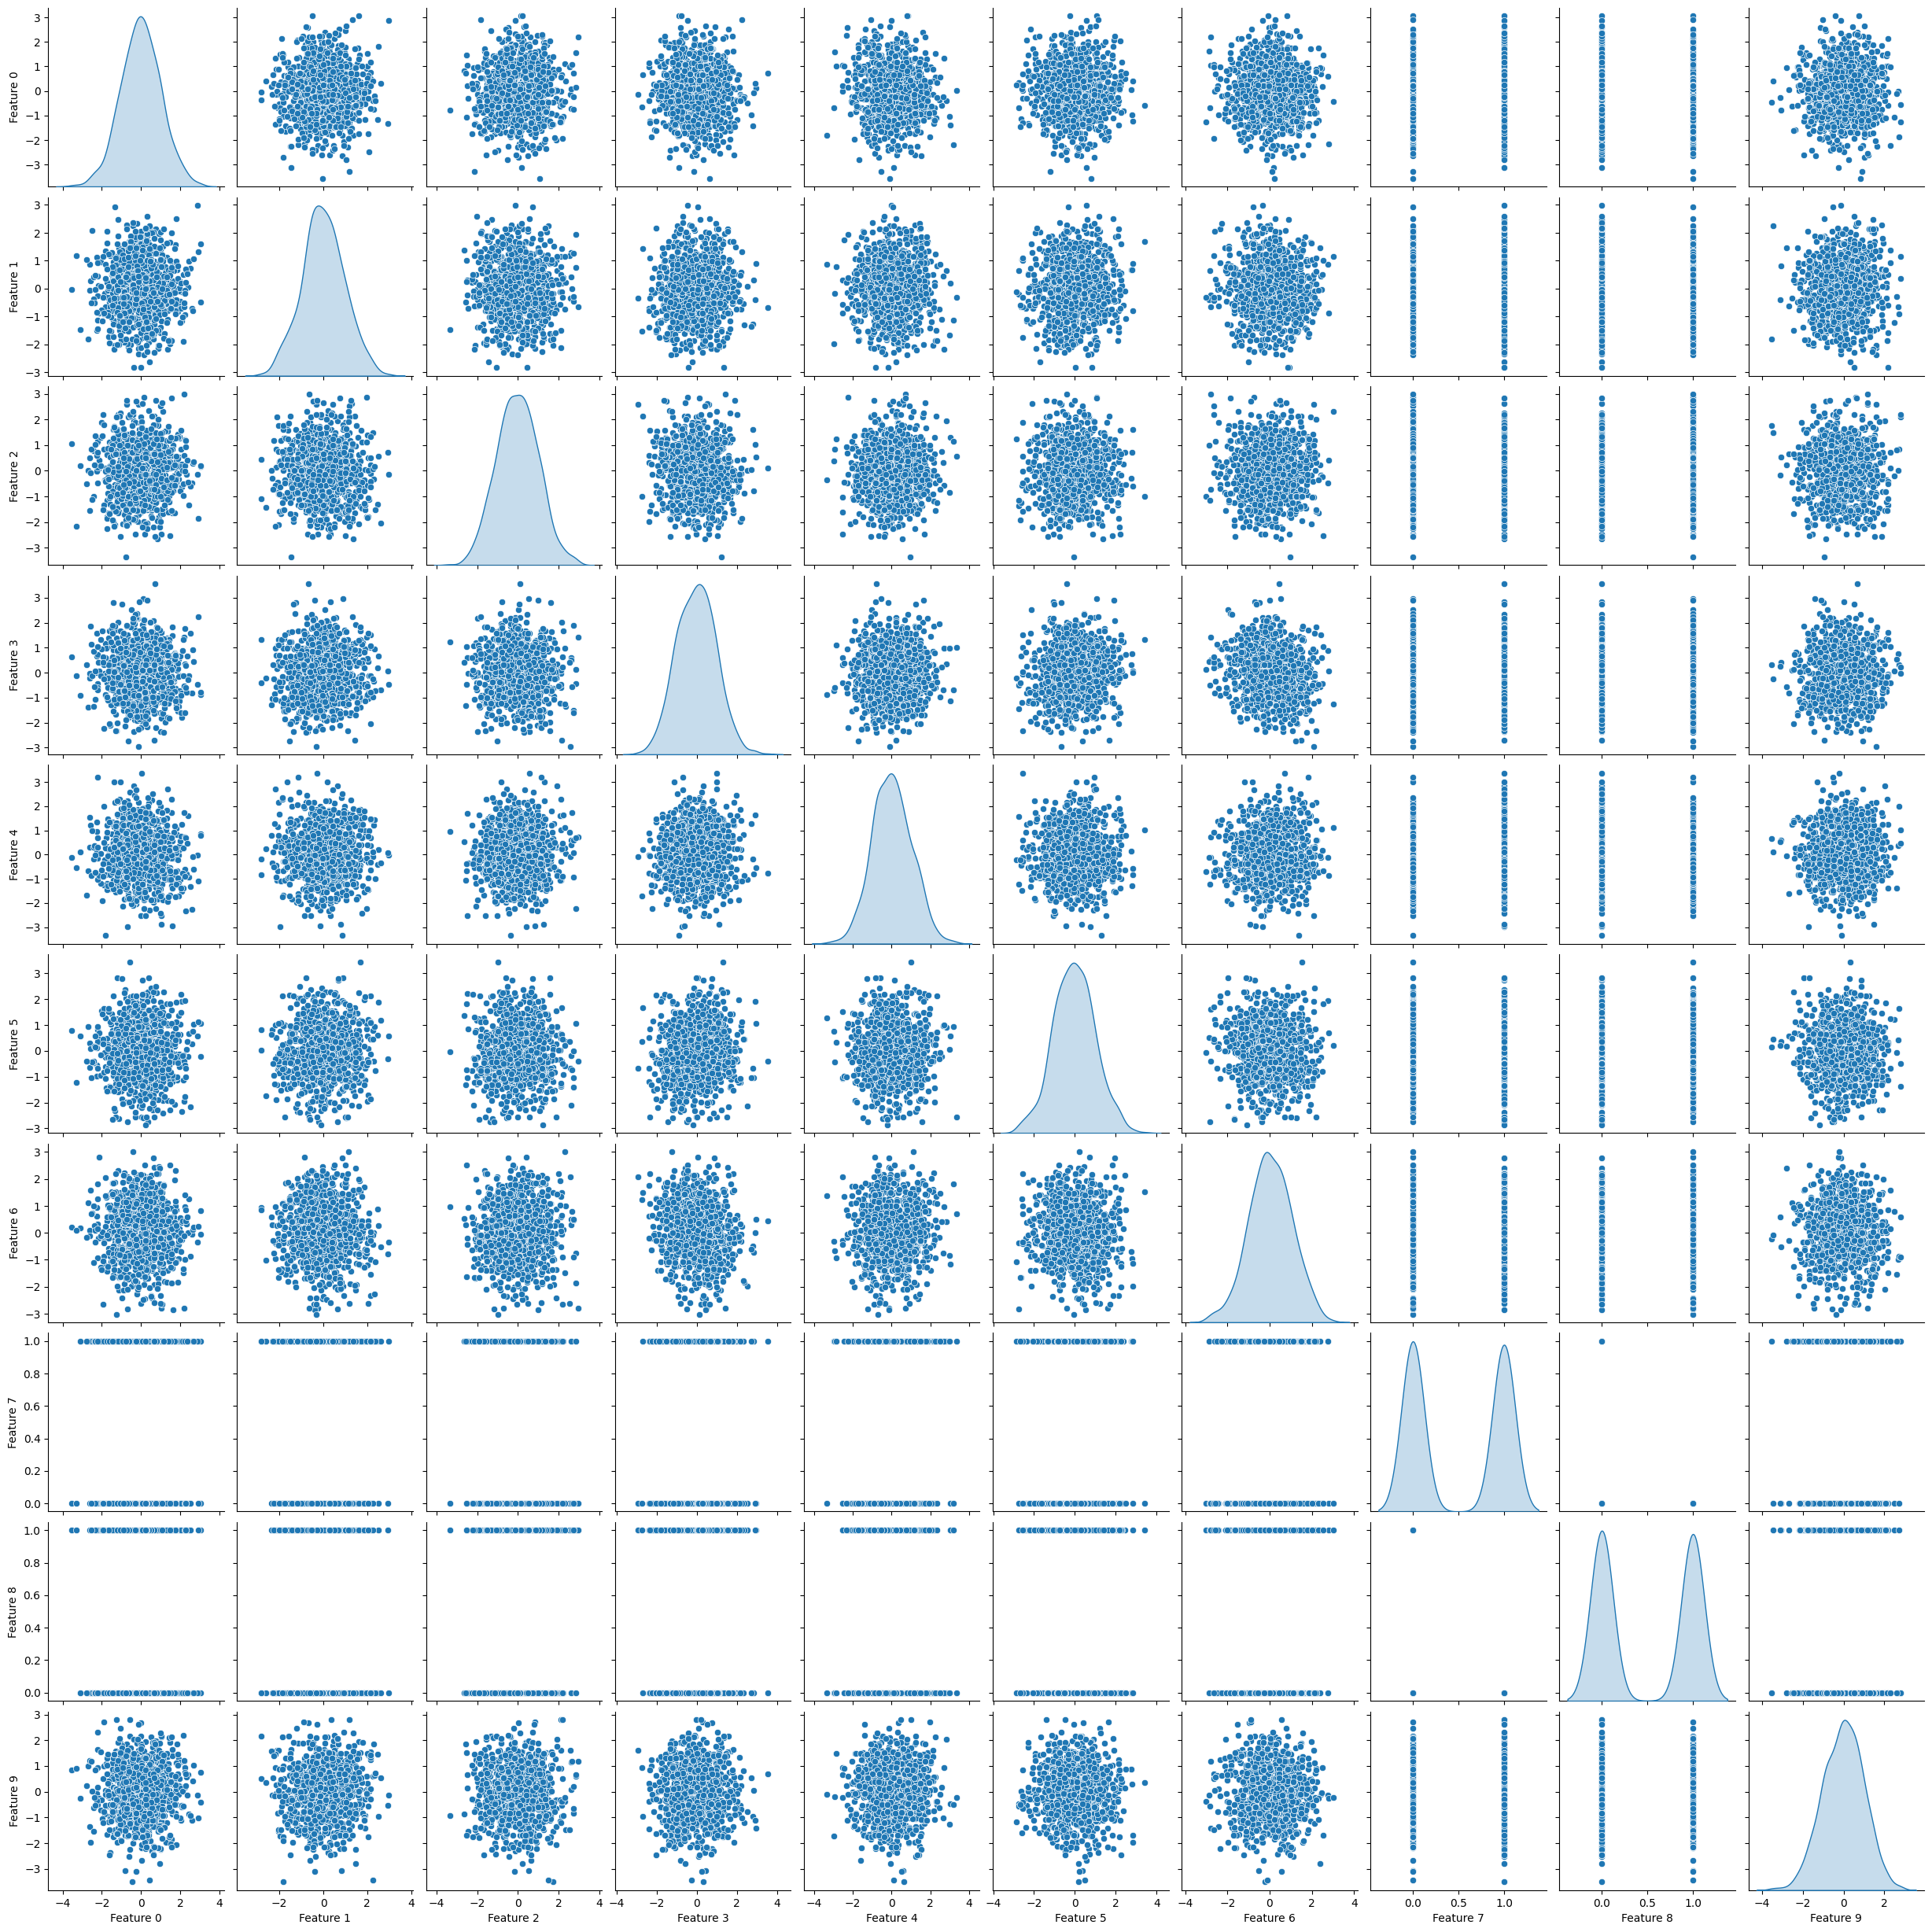

In [34]:
# Create a DataFrame from the feature matrix X and feature names list
df = pd.DataFrame(X, columns=[f"Feature {i}" for i in range(X.shape[1])])

# Create a list of feature names
feature_names = [f"Feature {i}" for i in range(X.shape[1])]

# Create the pair-wise scatterplot matrix
sns.pairplot(df, diag_kind='kde', vars=feature_names)
plt.show()


There are multiple features with high coefficients, but I would like to focus on features 7 and 8. When I inspect them further, I see that they are both binary  and mutually exclusive. And also, they cover almost the entire dataset (in 99% of the samples, exactly one of them is true (=1). Also they are barely correlated to the outcome by themselves.

In [35]:
# feature 7 and 8 are binary
np.unique(X[:,7]), np.unique(X[:,8])

(array([0., 1.]), array([0., 1.]))

In [36]:
# feature 7 and 8 are mutually exclusive
((X[:,7] == 1) & (X[:,8] == 1)).sum()

0

In [37]:
# feature 7 and 8 nearly cover the whole dataset!
((X[:,7] == 1) | (X[:,8] == 1)).sum() / X.shape[0]

0.99

## Tasks

In this case, I would not expect both feature 7 and feature 8 to have such a high importance for the model and on top of that both positive! What is going on? Even if you do not find a precise answer, please show all your analyses here and explain your reasoning.

It may appear contradictory at first to describe a case where features 7 and 8 are both very significant to the model and have a positive correlation with the target variable. Here are a few explanations that could apply to this situation:

**Collinearity**, **Interaction effects** and **Feature engineering**, which we checked above and explained it.

